### Next word prediction using LSTM

In [1]:
# Using tensorflow version 2.x.x
import tensorflow
tensorflow.__version__

'2.9.2'

In [2]:
# Importing the libraries
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
3# Reading the text file and checking its length
PATH = r"/content/sample_data/1661-0.txt"
text = open(PATH).read().lower()
print("Length of the text", len(text))

Length of the text 581888


In [4]:
# Now spliting the dataset into each word in order but without the presence of some special characters.
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [5]:
len(words)

109226

In [6]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [7]:
len(unique_word_index)

8201

In [8]:
WORD_LENGTH = 6
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures', 'of']
sherlock


In [9]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [10]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [ ]:
optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=30, shuffle=True).history

In [ ]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

In [ ]:
history

{'loss': [5.892911911010742, 4.77471923828125],
 'accuracy': [0.11381213366985321, 0.19139893352985382],
 'val_loss': [6.670966625213623, 6.643269062042236],
 'val_accuracy': [0.1289643943309784, 0.1401294469833374]}

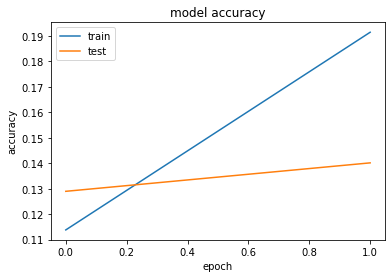

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

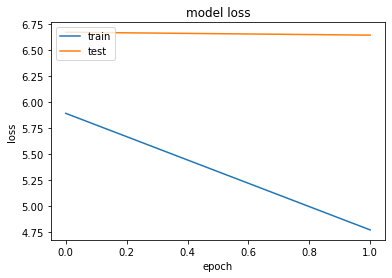

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [ ]:
prepare_input("This is an example of input for our LSTM".lower())

In [ ]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()